In [1]:
import os

max_files = 50  # number of files to print
count = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count += 1
        if count >= max_files:
            break
    if count >= max_files:
        break

/kaggle/input/nih-chest-x-rays-preprocessed-version/README_CHESTXRAY.pdf
/kaggle/input/nih-chest-x-rays-preprocessed-version/BBox_List_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/test_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/Data_Entry_2017.csv
/kaggle/input/nih-chest-x-rays-preprocessed-version/train_val_list.txt
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006199_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004833_016.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00006260_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004911_010.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004186_007.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00004459_000.png
/kaggle/input/nih-chest-x-rays-preprocessed-version/images_003/images/00005004_001.png
/kaggle/input/nih-chest-x-rays-preproc

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import wandb
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix, multilabel_confusion_matrix
import numpy as np
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# ---------------- CONFIG ---------------- #
CONFIG = {
    "model": "efficientnet_b3_implementation",
    "batch_size": 4,  # Reduced due to larger image size and model
    "learning_rate": 0.00005,
    "epochs": 25,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/nih-chest-x-rays-preprocessed-version",  # <- CHANGE to your Kaggle dataset path
    "patience": 5,
    "seed": 42,
    "image_size": 300,  # EfficientNet-B3's native resolution
}

In [5]:
print(CONFIG["device"])

cuda


In [6]:
# ---------------- TRANSFORMS ---------------- #
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(CONFIG["image_size"]),  # Use config
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(CONFIG["image_size"] + 28),  # Add margin
    transforms.CenterCrop(CONFIG["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [7]:
# ---------------- MODEL ---------------- #
model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
# EfficientNet classifier is a Sequential module: [Dropout, Linear]
# We need to access the Linear layer (index 1) to get in_features
num_features = model.classifier[1].in_features
model.classifier = nn.Linear(num_features, 14)
model = model.to(CONFIG["device"])

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 176MB/s]


In [8]:
# ---------------- LOSS ---------------- #
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [9]:
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)

In [10]:
# ---------------- DATA ---------------- #
data_path = CONFIG["data_dir"]
csv_file = os.path.join(data_path, "Data_Entry_2017.csv")
df = pd.read_csv(csv_file)

In [11]:
image_folders = [os.path.join(data_path, f"images_{str(i).zfill(3)}", "images") for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for img_file in os.listdir(folder):
            if img_file.endswith('.png'):
                image_to_folder[img_file] = folder


In [12]:
df = df[df['Image Index'].isin(image_to_folder.keys())]

In [13]:
unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=CONFIG["seed"])
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.052, random_state=CONFIG["seed"])

In [14]:
train_df = df[df['Patient ID'].isin(train_patients)]
val_df   = df[df['Patient ID'].isin(val_patients)]
test_df  = df[df['Patient ID'].isin(test_patients)]

In [15]:
disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

In [16]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    else:
        return [1 if disease in labels else 0 for disease in disease_list]

In [17]:
class CheXNetDataset(Dataset):
    def __init__(self, dataframe, image_to_folder, transform=None):
        self.dataframe = dataframe
        self.image_to_folder = image_to_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        folder = self.image_to_folder[img_name]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels_str = self.dataframe.iloc[idx]['Finding Labels']
        labels = torch.tensor(get_label_vector(labels_str), dtype=torch.float)
        return image, labels

In [18]:
trainloader = DataLoader(CheXNetDataset(train_df, image_to_folder, transform=transform_train),
                         batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
valloader = DataLoader(CheXNetDataset(val_df, image_to_folder, transform=transform_test),
                       batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
testloader = DataLoader(CheXNetDataset(test_df, image_to_folder, transform=transform_test),
                        batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

In [19]:
# ---------------- METRICS ---------------- #
def get_optimal_thresholds(labels, preds):
    thresholds = []
    for i in range(preds.shape[1]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    return thresholds

In [20]:
def evaluate(model, loader, criterion, device, desc="[Test]"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=desc):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    thresholds = get_optimal_thresholds(all_labels, all_preds)

    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        preds_binary[:, i] = (all_preds[:, i] > thresholds[i]).astype(int)

    auc_scores = [roc_auc_score(all_labels[:, i], all_preds[:, i]) for i in range(14)]
    f1_scores = [f1_score(all_labels[:, i], preds_binary[:, i]) for i in range(14)]

    avg_auc = np.mean(auc_scores)
    avg_f1 = np.mean(f1_scores)

    for i, disease in enumerate(disease_list):
        print(f"{desc} {disease} AUC: {auc_scores[i]:.4f} | F1: {f1_scores[i]:.4f}")

    print(f"{desc} Avg AUC: {avg_auc:.4f}, Avg F1: {avg_f1:.4f}")

    return {
        "loss": running_loss / len(loader),
        "avg_auc": avg_auc,
        "avg_f1": avg_f1,
        "auc_dict": dict(zip(disease_list, auc_scores)),
        "f1_dict": dict(zip(disease_list, f1_scores)),
        "thresholds": dict(zip(disease_list, thresholds))
    }


In [21]:
# ---------------- TRAINING ---------------- #
def train(epoch, model, trainloader, optimizer, criterion, CONFIG):
    device = CONFIG["device"]
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=True)
    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({"loss": running_loss / (i + 1)})
    train_loss = running_loss / len(trainloader)
    return train_loss


In [22]:
def validate(model, valloader, criterion, device):
    return evaluate(model, valloader, criterion, device, desc="[Validate]")


In [23]:
# ---------------- MAIN LOOP ---------------- #
checkpoint_dir = "models"
os.makedirs(checkpoint_dir, exist_ok=True)

best_val_auc = 0.0
patience_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []
epochs_list = []

print("Starting training...")
print("-" * 80)

for epoch in range(CONFIG["epochs"]):
    print(f"\nEpoch {epoch+1}/{CONFIG['epochs']}")
    print("-" * 40)
    
    # Training
    train_loss = train(epoch, model, trainloader, optimizer, criterion, CONFIG)
    
    # Validation
    val_stats = validate(model, valloader, criterion, CONFIG["device"])
    
    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_stats["loss"])
    epochs_list.append(epoch + 1)
    
    # Display epoch summary
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_stats['loss']:.4f}")
    print(f"Validation AUC: {val_stats['avg_auc']:.4f}")
    print(f"Validation F1: {val_stats['avg_f1']:.4f}")
    
    scheduler.step(val_stats["loss"])

    if val_stats["avg_auc"] > best_val_auc:
        best_val_auc = val_stats["avg_auc"]
        patience_counter = 0
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_{timestamp}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✓ NEW BEST MODEL! Saved at {checkpoint_path}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
        if patience_counter >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

print("\nTraining completed!")
print("-" * 80)

Starting training...
--------------------------------------------------------------------------------

Epoch 1/25
----------------------------------------


Epoch 1/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8031 | F1: 0.3851
[Validate] Cardiomegaly AUC: 0.8578 | F1: 0.2963
[Validate] Consolidation AUC: 0.7818 | F1: 0.2196
[Validate] Edema AUC: 0.8670 | F1: 0.1971
[Validate] Effusion AUC: 0.8502 | F1: 0.4878
[Validate] Emphysema AUC: 0.8955 | F1: 0.4100
[Validate] Fibrosis AUC: 0.8067 | F1: 0.1423
[Validate] Hernia AUC: 0.7687 | F1: 0.0260
[Validate] Infiltration AUC: 0.6958 | F1: 0.4146
[Validate] Mass AUC: 0.7903 | F1: 0.3333
[Validate] Nodule AUC: 0.7435 | F1: 0.2827
[Validate] Pleural_Thickening AUC: 0.7738 | F1: 0.2045
[Validate] Pneumonia AUC: 0.6158 | F1: 0.0486
[Validate] Pneumothorax AUC: 0.8606 | F1: 0.4222
[Validate] Avg AUC: 0.7936, Avg F1: 0.2764
Training Loss: 0.0466
Validation Loss: 0.0434
Validation AUC: 0.7936
Validation F1: 0.2764
✓ NEW BEST MODEL! Saved at models/best_model_20250915-115304.pth

Epoch 2/25
----------------------------------------


Epoch 2/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.7988 | F1: 0.3869
[Validate] Cardiomegaly AUC: 0.8669 | F1: 0.3300
[Validate] Consolidation AUC: 0.7644 | F1: 0.2145
[Validate] Edema AUC: 0.8758 | F1: 0.2232
[Validate] Effusion AUC: 0.8483 | F1: 0.4793
[Validate] Emphysema AUC: 0.9068 | F1: 0.4836
[Validate] Fibrosis AUC: 0.8165 | F1: 0.1771
[Validate] Hernia AUC: 0.8763 | F1: 0.1304
[Validate] Infiltration AUC: 0.7091 | F1: 0.4315
[Validate] Mass AUC: 0.7862 | F1: 0.3681
[Validate] Nodule AUC: 0.7636 | F1: 0.3343
[Validate] Pleural_Thickening AUC: 0.7985 | F1: 0.2522
[Validate] Pneumonia AUC: 0.7123 | F1: 0.0774
[Validate] Pneumothorax AUC: 0.8787 | F1: 0.4518
[Validate] Avg AUC: 0.8145, Avg F1: 0.3100
Training Loss: 0.0436
Validation Loss: 0.0433
Validation AUC: 0.8145
Validation F1: 0.3100
✓ NEW BEST MODEL! Saved at models/best_model_20250915-123547.pth

Epoch 3/25
----------------------------------------


Epoch 3/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8252 | F1: 0.4029
[Validate] Cardiomegaly AUC: 0.8855 | F1: 0.3522
[Validate] Consolidation AUC: 0.7970 | F1: 0.2384
[Validate] Edema AUC: 0.8725 | F1: 0.2091
[Validate] Effusion AUC: 0.8607 | F1: 0.5163
[Validate] Emphysema AUC: 0.9268 | F1: 0.5468
[Validate] Fibrosis AUC: 0.8083 | F1: 0.1838
[Validate] Hernia AUC: 0.9049 | F1: 0.2778
[Validate] Infiltration AUC: 0.7080 | F1: 0.4369
[Validate] Mass AUC: 0.8319 | F1: 0.3656
[Validate] Nodule AUC: 0.7612 | F1: 0.3338
[Validate] Pleural_Thickening AUC: 0.7931 | F1: 0.2301
[Validate] Pneumonia AUC: 0.7451 | F1: 0.0821
[Validate] Pneumothorax AUC: 0.8996 | F1: 0.4588
[Validate] Avg AUC: 0.8300, Avg F1: 0.3310
Training Loss: 0.0425
Validation Loss: 0.0422
Validation AUC: 0.8300
Validation F1: 0.3310
✓ NEW BEST MODEL! Saved at models/best_model_20250915-131956.pth

Epoch 4/25
----------------------------------------


Epoch 4/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8277 | F1: 0.4120
[Validate] Cardiomegaly AUC: 0.8942 | F1: 0.3765
[Validate] Consolidation AUC: 0.8057 | F1: 0.2743
[Validate] Edema AUC: 0.8738 | F1: 0.2005
[Validate] Effusion AUC: 0.8622 | F1: 0.5063
[Validate] Emphysema AUC: 0.9274 | F1: 0.5176
[Validate] Fibrosis AUC: 0.8255 | F1: 0.1988
[Validate] Hernia AUC: 0.9210 | F1: 0.4400
[Validate] Infiltration AUC: 0.7095 | F1: 0.4194
[Validate] Mass AUC: 0.8308 | F1: 0.3974
[Validate] Nodule AUC: 0.7733 | F1: 0.3758
[Validate] Pleural_Thickening AUC: 0.8079 | F1: 0.2531
[Validate] Pneumonia AUC: 0.7508 | F1: 0.0708
[Validate] Pneumothorax AUC: 0.9028 | F1: 0.4663
[Validate] Avg AUC: 0.8366, Avg F1: 0.3506
Training Loss: 0.0417
Validation Loss: 0.0411
Validation AUC: 0.8366
Validation F1: 0.3506
✓ NEW BEST MODEL! Saved at models/best_model_20250915-140417.pth

Epoch 5/25
----------------------------------------


Epoch 5/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8370 | F1: 0.4150
[Validate] Cardiomegaly AUC: 0.8883 | F1: 0.4138
[Validate] Consolidation AUC: 0.7991 | F1: 0.2549
[Validate] Edema AUC: 0.8820 | F1: 0.2342
[Validate] Effusion AUC: 0.8731 | F1: 0.5171
[Validate] Emphysema AUC: 0.9192 | F1: 0.5000
[Validate] Fibrosis AUC: 0.8257 | F1: 0.1898
[Validate] Hernia AUC: 0.9507 | F1: 0.4889
[Validate] Infiltration AUC: 0.7075 | F1: 0.4200
[Validate] Mass AUC: 0.8463 | F1: 0.4250
[Validate] Nodule AUC: 0.7614 | F1: 0.3468
[Validate] Pleural_Thickening AUC: 0.8220 | F1: 0.2727
[Validate] Pneumonia AUC: 0.7670 | F1: 0.0794
[Validate] Pneumothorax AUC: 0.8916 | F1: 0.4150
[Validate] Avg AUC: 0.8408, Avg F1: 0.3552
Training Loss: 0.0412
Validation Loss: 0.0405
Validation AUC: 0.8408
Validation F1: 0.3552
✓ NEW BEST MODEL! Saved at models/best_model_20250915-144836.pth

Epoch 6/25
----------------------------------------


Epoch 6/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8401 | F1: 0.4243
[Validate] Cardiomegaly AUC: 0.8804 | F1: 0.3883
[Validate] Consolidation AUC: 0.7867 | F1: 0.2473
[Validate] Edema AUC: 0.8817 | F1: 0.2186
[Validate] Effusion AUC: 0.8692 | F1: 0.5087
[Validate] Emphysema AUC: 0.9202 | F1: 0.4830
[Validate] Fibrosis AUC: 0.8158 | F1: 0.2232
[Validate] Hernia AUC: 0.9264 | F1: 0.4211
[Validate] Infiltration AUC: 0.7118 | F1: 0.4315
[Validate] Mass AUC: 0.8421 | F1: 0.4253
[Validate] Nodule AUC: 0.7523 | F1: 0.3239
[Validate] Pleural_Thickening AUC: 0.8126 | F1: 0.2429
[Validate] Pneumonia AUC: 0.7682 | F1: 0.0889
[Validate] Pneumothorax AUC: 0.8810 | F1: 0.4076
[Validate] Avg AUC: 0.8349, Avg F1: 0.3453
Training Loss: 0.0408
Validation Loss: 0.0408
Validation AUC: 0.8349
Validation F1: 0.3453
No improvement. Patience: 1/5

Epoch 7/25
----------------------------------------


Epoch 7/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc92fd68040><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc92fd68040>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             Exception ignored in: ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc92fd68040>^Exception ignored in: 
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/tor

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8426 | F1: 0.4275
[Validate] Cardiomegaly AUC: 0.8760 | F1: 0.4152
[Validate] Consolidation AUC: 0.7961 | F1: 0.2500
[Validate] Edema AUC: 0.8754 | F1: 0.2014
[Validate] Effusion AUC: 0.8620 | F1: 0.5106
[Validate] Emphysema AUC: 0.9253 | F1: 0.5193
[Validate] Fibrosis AUC: 0.7984 | F1: 0.2282
[Validate] Hernia AUC: 0.9777 | F1: 0.5714
[Validate] Infiltration AUC: 0.7139 | F1: 0.4335
[Validate] Mass AUC: 0.8636 | F1: 0.4131
[Validate] Nodule AUC: 0.7651 | F1: 0.3498
[Validate] Pleural_Thickening AUC: 0.8182 | F1: 0.2623
[Validate] Pneumonia AUC: 0.7643 | F1: 0.0855
[Validate] Pneumothorax AUC: 0.9060 | F1: 0.4490
[Validate] Avg AUC: 0.8418, Avg F1: 0.3655
Training Loss: 0.0405
Validation Loss: 0.0406
Validation AUC: 0.8418
Validation F1: 0.3655
✓ NEW BEST MODEL! Saved at models/best_model_20250915-161713.pth

Epoch 8/25
----------------------------------------


Epoch 8/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8445 | F1: 0.4293
[Validate] Cardiomegaly AUC: 0.8935 | F1: 0.3880
[Validate] Consolidation AUC: 0.7980 | F1: 0.2686
[Validate] Edema AUC: 0.8858 | F1: 0.2029
[Validate] Effusion AUC: 0.8731 | F1: 0.5179
[Validate] Emphysema AUC: 0.9267 | F1: 0.5168
[Validate] Fibrosis AUC: 0.8231 | F1: 0.2176
[Validate] Hernia AUC: 0.9683 | F1: 0.5306
[Validate] Infiltration AUC: 0.7119 | F1: 0.4211
[Validate] Mass AUC: 0.8649 | F1: 0.4130
[Validate] Nodule AUC: 0.7653 | F1: 0.3146
[Validate] Pleural_Thickening AUC: 0.8304 | F1: 0.2346
[Validate] Pneumonia AUC: 0.7813 | F1: 0.0923
[Validate] Pneumothorax AUC: 0.9012 | F1: 0.4200
[Validate] Avg AUC: 0.8477, Avg F1: 0.3548
Training Loss: 0.0394
Validation Loss: 0.0407
Validation AUC: 0.8477
Validation F1: 0.3548
✓ NEW BEST MODEL! Saved at models/best_model_20250915-170120.pth

Epoch 9/25
----------------------------------------


Epoch 9/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8475 | F1: 0.4298
[Validate] Cardiomegaly AUC: 0.8954 | F1: 0.3936
[Validate] Consolidation AUC: 0.8031 | F1: 0.2635
[Validate] Edema AUC: 0.8877 | F1: 0.2368
[Validate] Effusion AUC: 0.8741 | F1: 0.5129
[Validate] Emphysema AUC: 0.9314 | F1: 0.5102
[Validate] Fibrosis AUC: 0.8372 | F1: 0.2128
[Validate] Hernia AUC: 0.9693 | F1: 0.5532
[Validate] Infiltration AUC: 0.7129 | F1: 0.4234
[Validate] Mass AUC: 0.8674 | F1: 0.4165
[Validate] Nodule AUC: 0.7664 | F1: 0.3286
[Validate] Pleural_Thickening AUC: 0.8319 | F1: 0.2469
[Validate] Pneumonia AUC: 0.7863 | F1: 0.0943
[Validate] Pneumothorax AUC: 0.9008 | F1: 0.4314
[Validate] Avg AUC: 0.8508, Avg F1: 0.3610
Training Loss: 0.0391
Validation Loss: 0.0402
Validation AUC: 0.8508
Validation F1: 0.3610
✓ NEW BEST MODEL! Saved at models/best_model_20250915-174537.pth

Epoch 10/25
----------------------------------------


Epoch 10/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8443 | F1: 0.4240
[Validate] Cardiomegaly AUC: 0.8913 | F1: 0.3879
[Validate] Consolidation AUC: 0.7979 | F1: 0.2620
[Validate] Edema AUC: 0.8831 | F1: 0.2183
[Validate] Effusion AUC: 0.8699 | F1: 0.5054
[Validate] Emphysema AUC: 0.9273 | F1: 0.4949
[Validate] Fibrosis AUC: 0.8265 | F1: 0.2194
[Validate] Hernia AUC: 0.9595 | F1: 0.5417
[Validate] Infiltration AUC: 0.7102 | F1: 0.4152
[Validate] Mass AUC: 0.8649 | F1: 0.4230
[Validate] Nodule AUC: 0.7665 | F1: 0.3176
[Validate] Pleural_Thickening AUC: 0.8274 | F1: 0.2319
[Validate] Pneumonia AUC: 0.7863 | F1: 0.0870
[Validate] Pneumothorax AUC: 0.8882 | F1: 0.4115
[Validate] Avg AUC: 0.8460, Avg F1: 0.3528
Training Loss: 0.0389
Validation Loss: 0.0404
Validation AUC: 0.8460
Validation F1: 0.3528
No improvement. Patience: 1/5

Epoch 11/25
----------------------------------------


Epoch 11/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8446 | F1: 0.4287
[Validate] Cardiomegaly AUC: 0.8875 | F1: 0.3854
[Validate] Consolidation AUC: 0.7987 | F1: 0.2646
[Validate] Edema AUC: 0.8845 | F1: 0.2216
[Validate] Effusion AUC: 0.8709 | F1: 0.5102
[Validate] Emphysema AUC: 0.9268 | F1: 0.4724
[Validate] Fibrosis AUC: 0.8272 | F1: 0.2148
[Validate] Hernia AUC: 0.9610 | F1: 0.5217
[Validate] Infiltration AUC: 0.7128 | F1: 0.4165
[Validate] Mass AUC: 0.8665 | F1: 0.4132
[Validate] Nodule AUC: 0.7665 | F1: 0.3214
[Validate] Pleural_Thickening AUC: 0.8276 | F1: 0.2415
[Validate] Pneumonia AUC: 0.7926 | F1: 0.0794
[Validate] Pneumothorax AUC: 0.8906 | F1: 0.4230
[Validate] Avg AUC: 0.8470, Avg F1: 0.3510
Training Loss: 0.0388
Validation Loss: 0.0404
Validation AUC: 0.8470
Validation F1: 0.3510
No improvement. Patience: 2/5

Epoch 12/25
----------------------------------------


Epoch 12/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8449 | F1: 0.4285
[Validate] Cardiomegaly AUC: 0.8891 | F1: 0.3860
[Validate] Consolidation AUC: 0.7995 | F1: 0.2637
[Validate] Edema AUC: 0.8830 | F1: 0.2191
[Validate] Effusion AUC: 0.8716 | F1: 0.5130
[Validate] Emphysema AUC: 0.9269 | F1: 0.4910
[Validate] Fibrosis AUC: 0.8312 | F1: 0.2209
[Validate] Hernia AUC: 0.9612 | F1: 0.5217
[Validate] Infiltration AUC: 0.7138 | F1: 0.4210
[Validate] Mass AUC: 0.8682 | F1: 0.4153
[Validate] Nodule AUC: 0.7677 | F1: 0.3261
[Validate] Pleural_Thickening AUC: 0.8271 | F1: 0.2369
[Validate] Pneumonia AUC: 0.7873 | F1: 0.0898
[Validate] Pneumothorax AUC: 0.8915 | F1: 0.4339
[Validate] Avg AUC: 0.8474, Avg F1: 0.3548
Training Loss: 0.0386
Validation Loss: 0.0400
Validation AUC: 0.8474
Validation F1: 0.3548
No improvement. Patience: 3/5

Epoch 13/25
----------------------------------------


Epoch 13/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8449 | F1: 0.4351
[Validate] Cardiomegaly AUC: 0.8895 | F1: 0.3832
[Validate] Consolidation AUC: 0.8000 | F1: 0.2675
[Validate] Edema AUC: 0.8846 | F1: 0.2229
[Validate] Effusion AUC: 0.8717 | F1: 0.5135
[Validate] Emphysema AUC: 0.9289 | F1: 0.4651
[Validate] Fibrosis AUC: 0.8314 | F1: 0.2252
[Validate] Hernia AUC: 0.9620 | F1: 0.5581
[Validate] Infiltration AUC: 0.7106 | F1: 0.4165
[Validate] Mass AUC: 0.8674 | F1: 0.4148
[Validate] Nodule AUC: 0.7666 | F1: 0.3157
[Validate] Pleural_Thickening AUC: 0.8295 | F1: 0.2403
[Validate] Pneumonia AUC: 0.7914 | F1: 0.0917
[Validate] Pneumothorax AUC: 0.8900 | F1: 0.4276
[Validate] Avg AUC: 0.8477, Avg F1: 0.3555
Training Loss: 0.0386
Validation Loss: 0.0402
Validation AUC: 0.8477
Validation F1: 0.3555
No improvement. Patience: 4/5

Epoch 14/25
----------------------------------------


Epoch 14/25 [Train]:   0%|          | 0/25962 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/1494 [00:00<?, ?it/s]

[Validate] Atelectasis AUC: 0.8444 | F1: 0.4223
[Validate] Cardiomegaly AUC: 0.8897 | F1: 0.3803
[Validate] Consolidation AUC: 0.8000 | F1: 0.2697
[Validate] Edema AUC: 0.8839 | F1: 0.2094
[Validate] Effusion AUC: 0.8717 | F1: 0.5155
[Validate] Emphysema AUC: 0.9263 | F1: 0.4966
[Validate] Fibrosis AUC: 0.8241 | F1: 0.2295
[Validate] Hernia AUC: 0.9612 | F1: 0.5455
[Validate] Infiltration AUC: 0.7091 | F1: 0.4129
[Validate] Mass AUC: 0.8661 | F1: 0.4162
[Validate] Nodule AUC: 0.7652 | F1: 0.3072
[Validate] Pleural_Thickening AUC: 0.8260 | F1: 0.2429
[Validate] Pneumonia AUC: 0.7875 | F1: 0.0844
[Validate] Pneumothorax AUC: 0.8940 | F1: 0.4179
[Validate] Avg AUC: 0.8464, Avg F1: 0.3536
Training Loss: 0.0386
Validation Loss: 0.0403
Validation AUC: 0.8464
Validation F1: 0.3536
No improvement. Patience: 5/5
Early stopping triggered.

Training completed!
--------------------------------------------------------------------------------


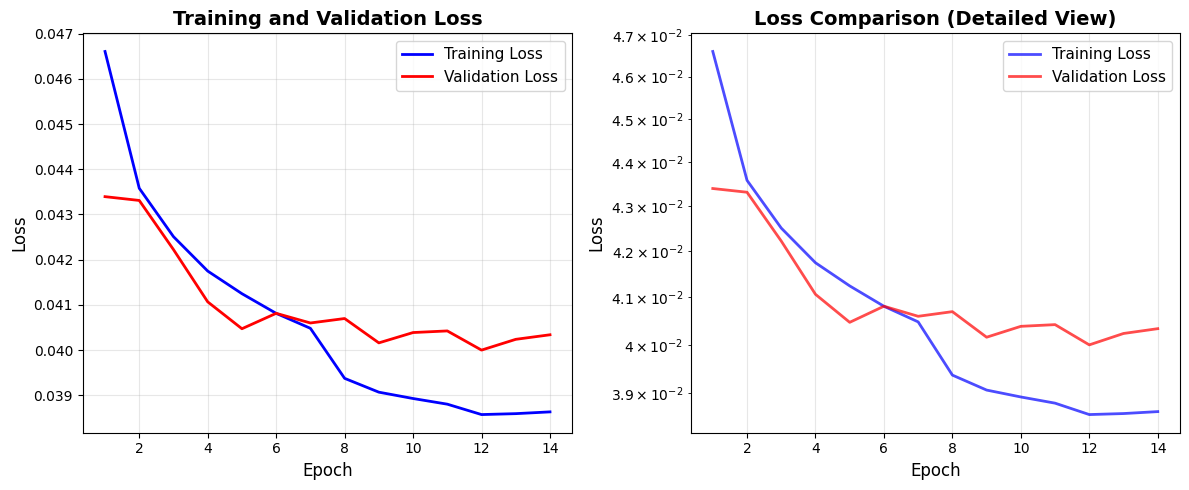


===== TRAINING SUMMARY =====
Final Training Loss: 0.0386
Final Validation Loss: 0.0403
Best Validation AUC: 0.8508
Total Epochs Trained: 14
Training stopped due to early stopping.


In [24]:
# ---------------- PLOT TRAINING CURVES ---------------- #
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot validation AUC if available
if len(train_losses) > 0:
    plt.subplot(1, 2, 2)
    # We can't plot AUC here directly since we didn't store it, but we can show the loss comparison
    plt.plot(epochs_list, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs_list, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
    plt.title('Loss Comparison (Detailed View)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss summary
print("\n===== TRAINING SUMMARY =====")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Total Epochs Trained: {len(train_losses)}")
if patience_counter >= CONFIG["patience"]:
    print("Training stopped due to early stopping.")

In [25]:
# ---------------- TEST ---------------- #
best_checkpoint_path = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('best_model_')])[-1]
model.load_state_dict(torch.load(best_checkpoint_path))
test_stats = evaluate(model, testloader, criterion, CONFIG["device"])

[Test]:   0%|          | 0/575 [00:00<?, ?it/s]

[Test] Atelectasis AUC: 0.8179 | F1: 0.4248
[Test] Cardiomegaly AUC: 0.9358 | F1: 0.4969
[Test] Consolidation AUC: 0.7693 | F1: 0.2353
[Test] Edema AUC: 0.8931 | F1: 0.2523
[Test] Effusion AUC: 0.9039 | F1: 0.6260
[Test] Emphysema AUC: 0.9451 | F1: 0.4706
[Test] Fibrosis AUC: 0.7671 | F1: 0.2034
[Test] Hernia AUC: 0.9659 | F1: 0.7500
[Test] Infiltration AUC: 0.6986 | F1: 0.3949
[Test] Mass AUC: 0.8975 | F1: 0.4615
[Test] Nodule AUC: 0.7779 | F1: 0.3422
[Test] Pleural_Thickening AUC: 0.7653 | F1: 0.2138
[Test] Pneumonia AUC: 0.7234 | F1: 0.0634
[Test] Pneumothorax AUC: 0.8736 | F1: 0.3484
[Test] Avg AUC: 0.8382, Avg F1: 0.3774


In [26]:
print("\n===== TEST RESULTS =====")

# Overall metrics
print(f"Loss      : {test_stats['loss']:.4f}")
print(f"Avg AUROC : {test_stats['avg_auc']:.4f}")
print(f"Avg F1    : {test_stats['avg_f1']:.4f}")

# Per-class metrics
print("\n=== Per-Class Metrics ===")
print("{:<20} {:<10} {:<10} {:<10}".format("Class", "AUROC", "F1", "Threshold"))
print("-" * 55)
for cls in test_stats['auc_dict'].keys():
    auc = test_stats['auc_dict'][cls]
    f1  = test_stats['f1_dict'][cls]
    thr = test_stats['thresholds'][cls]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f}".format(cls, auc, f1, thr))

# Optional: average threshold
avg_threshold = sum(test_stats['thresholds'].values()) / len(test_stats['thresholds'])
print("\nAverage Optimal Threshold across classes: {:.4f}".format(avg_threshold))



===== TEST RESULTS =====
Loss      : 0.0431
Avg AUROC : 0.8382
Avg F1    : 0.3774

=== Per-Class Metrics ===
Class                AUROC      F1         Threshold 
-------------------------------------------------------
Atelectasis          0.8179     0.4248     0.3774    
Cardiomegaly         0.9358     0.4969     0.3712    
Consolidation        0.7693     0.2353     0.3374    
Edema                0.8931     0.2523     0.3456    
Effusion             0.9039     0.6260     0.4513    
Emphysema            0.9451     0.4706     0.4068    
Fibrosis             0.7671     0.2034     0.4652    
Hernia               0.9659     0.7500     0.6678    
Infiltration         0.6986     0.3949     0.3807    
Mass                 0.8975     0.4615     0.3746    
Nodule               0.7779     0.3422     0.3060    
Pleural_Thickening   0.7653     0.2138     0.2850    
Pneumonia            0.7234     0.0634     0.1963    
Pneumothorax         0.8736     0.3484     0.3162    

Average Optimal Thresho

Generating predictions:   0%|          | 0/575 [00:00<?, ?it/s]

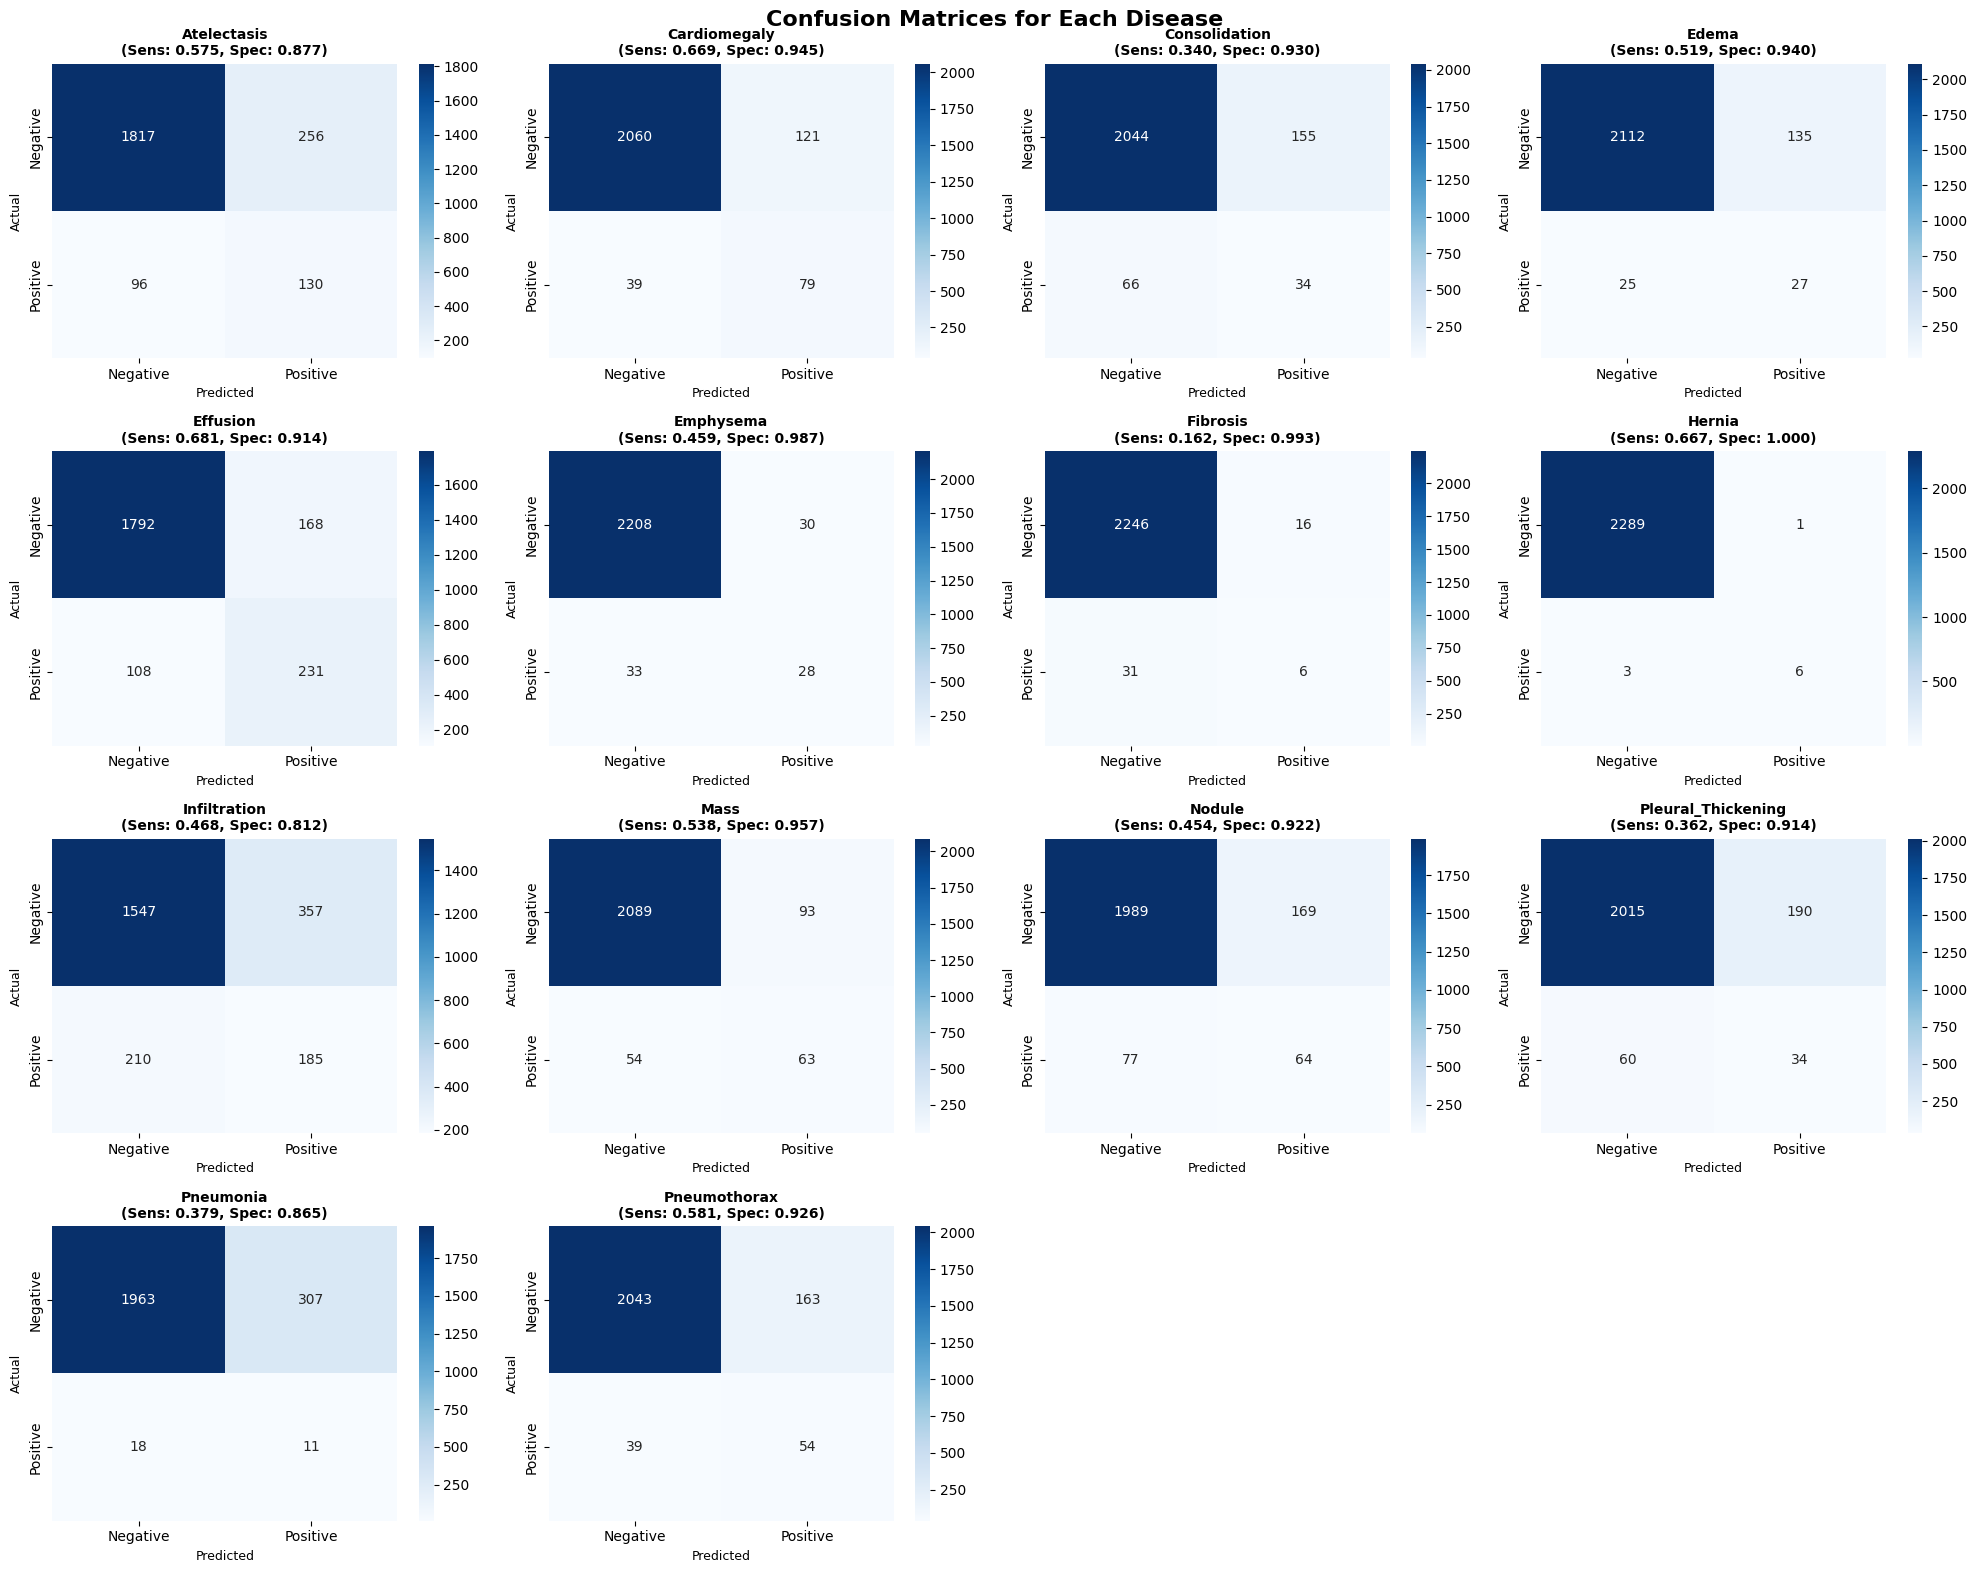

In [27]:
# ---------------- CONFUSION MATRIX ---------------- #
def generate_confusion_matrices(model, loader, device, thresholds):
    """
    Generate confusion matrices for multilabel classification.
    Since images can have multiple labels, we'll create individual confusion matrices for each disease.
    """
    model.eval()
    all_labels, all_preds = [], []
    
    print("Collecting predictions for confusion matrix...")
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Generating predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    
    # Convert predictions to binary using optimal thresholds
    preds_binary = np.zeros_like(all_preds)
    for i in range(all_preds.shape[1]):
        threshold = thresholds[disease_list[i]]
        preds_binary[:, i] = (all_preds[:, i] > threshold).astype(int)
    
    # Create confusion matrices for each disease
    n_diseases = len(disease_list)
    fig, axes = plt.subplots(4, 4, figsize=(20, 16))
    fig.suptitle('Confusion Matrices for Each Disease', fontsize=16, fontweight='bold')
    
    # Store confusion matrix metrics
    cm_metrics = {}
    
    for i, disease in enumerate(disease_list):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Generate confusion matrix for this disease
        cm = confusion_matrix(all_labels[:, i], preds_binary[:, i])
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        cm_metrics[disease] = {
            'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
            'Sensitivity': sensitivity, 'Specificity': specificity,
            'Precision': precision, 'NPV': npv
        }
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        ax.set_title(f'{disease}\n(Sens: {sensitivity:.3f}, Spec: {specificity:.3f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('Actual', fontsize=9)
    
    # Remove empty subplots (we have 14 diseases, so 2 empty spots)
    for i in range(n_diseases, 16):
        row = i // 4
        col = i % 4
        axes[row, col].remove()
    
    plt.tight_layout()
    plt.show()
    
    return cm_metrics

# Generate confusion matrices using test data and optimal thresholds
cm_metrics = generate_confusion_matrices(model, testloader, CONFIG["device"], test_stats['thresholds'])

In [28]:
# ---------------- DETAILED CONFUSION MATRIX METRICS ---------------- #
print("\n===== DETAILED CONFUSION MATRIX METRICS =====")
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8} {:<8} {:<8} {:<8}".format(
    "Disease", "TP", "TN", "FP", "FN", "Sens", "Spec", "Prec", "NPV"))
print("-" * 100)

for disease, metrics in cm_metrics.items():
    print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
        disease, 
        metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN'],
        metrics['Sensitivity'], metrics['Specificity'], 
        metrics['Precision'], metrics['NPV']
    ))

# Calculate and display average metrics
avg_sensitivity = np.mean([metrics['Sensitivity'] for metrics in cm_metrics.values()])
avg_specificity = np.mean([metrics['Specificity'] for metrics in cm_metrics.values()])
avg_precision = np.mean([metrics['Precision'] for metrics in cm_metrics.values()])
avg_npv = np.mean([metrics['NPV'] for metrics in cm_metrics.values()])

print("-" * 100)
print("{:<20} {:<6} {:<6} {:<6} {:<6} {:<8.3f} {:<8.3f} {:<8.3f} {:<8.3f}".format(
    "AVERAGE", "-", "-", "-", "-", avg_sensitivity, avg_specificity, avg_precision, avg_npv))

print(f"\n===== SUMMARY =====")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average NPV: {avg_npv:.4f}")

# Additional multilabel-specific metrics
print(f"\n===== MULTILABEL CHARACTERISTICS =====")
total_samples = len(testloader.dataset)
# Count samples with multiple labels
samples_with_multiple_labels = 0
samples_with_no_findings = 0

# Count samples with multiple labels and no findings
for labels in testloader.dataset.dataframe['Finding Labels']:
    label_vector = get_label_vector(labels)
    if sum(label_vector) == 0:
        samples_with_no_findings += 1
    elif sum(label_vector) > 1:
        samples_with_multiple_labels += 1

print(f"Samples with multiple labels: {samples_with_multiple_labels}")
print(f"Samples with no findings: {samples_with_no_findings}")
print(f"Total test samples: {total_samples}")
print("Note: This is a multilabel classification problem where each image can have multiple diseases simultaneously.")


===== DETAILED CONFUSION MATRIX METRICS =====
Disease              TP     TN     FP     FN     Sens     Spec     Prec     NPV     
----------------------------------------------------------------------------------------------------
Atelectasis          130    1817   256    96     0.575    0.877    0.337    0.950   
Cardiomegaly         79     2060   121    39     0.669    0.945    0.395    0.981   
Consolidation        34     2044   155    66     0.340    0.930    0.180    0.969   
Edema                27     2112   135    25     0.519    0.940    0.167    0.988   
Effusion             231    1792   168    108    0.681    0.914    0.579    0.943   
Emphysema            28     2208   30     33     0.459    0.987    0.483    0.985   
Fibrosis             6      2246   16     31     0.162    0.993    0.273    0.986   
Hernia               6      2289   1      3      0.667    1.000    0.857    0.999   
Infiltration         185    1547   357    210    0.468    0.812    0.341    0.880   
Ma